# Ungraded Lab Part 1 - Deploying a Machine Learning Model

Welcome to this ungraded lab!

This lab is all about deploying a real machine learning model, and checking what doing so feels like. More concretely, you will deploy a computer vision model trained to detect common objects in pictures. Deploying a model is one of the last steps in a prototypical machine learning lifecycle. However, we thought it would be exciting to get you to deploy a model right away. This lab uses a pretrained model called [`YOLOV3`](https://pjreddie.com/darknet/yolo/). This model is very convenient for two reasons: it runs really fast, and for object detection it yields accurate results.

The sequence of steps/tasks to complete in this lab are as follow:
1. Inspect the image data set used for object detection.
2. Take a look at the model itself.
3. Deploy the model using fastAPI. You can check its website [here](https://fastapi.tiangolo.com/).


Here is a [shortcut](#instructions) to the instructions on how to interact with your model once it has been deployed. **This will be useful later on, for now just continue with the notebook as usual.**

## Object Detection with YOLOV3

### Inspecting the images

Let's take a look at the images that will be passed to the YOLOV3 model. This will bring insight on what type of common objects are present for detection. These images are part of the [`ImageNet`](http://www.image-net.org/index) dataset and are stored within the `images` directory within this environment.

In [1]:
from IPython.display import Image, display


Displaying image: apple.jpg


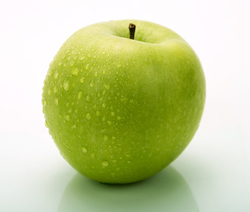


Displaying image: clock.jpg


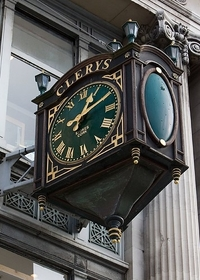


Displaying image: oranges.jpg


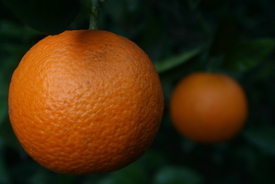


Displaying image: car.jpg


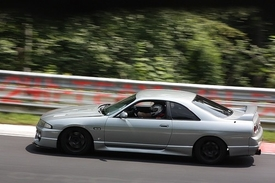

In [2]:
# Some example images
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

### Overview of the model

Now that you have a sense of the image data and the objects present, let's try and see if the model is able to detect and classify them correctly.

For this you will be using [`cvlib`](https://www.cvlib.net/), which is a very simple but powerful library for object detection that is fueled by [`OpenCV`](https://docs.opencv.org/4.5.1/) and [`Tensorflow`](https://www.tensorflow.org/).

More concretely, you will use the [`detect_common_objects`](https://docs.cvlib.net/object_detection/) function, which takes an image formatted as a [`numpy array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) and returns:

- `bbox`: list of list containing bounding box coordinates for detected objects. 

        Example:
    
    ```python
        [[32, 76, 128, 192], [130, 83, 220, 185]]
    ```
    

- `label`: list of labels for detected objects.
    
        Example:
    ```python
        ['apple', 'apple']
    ```


- `conf`: list of confidence scores for detected objects.
        Example:
        
    ```python
        [0.6187325716018677, 0.42835739254951477]
    ```
    
In the next section you will visually see these elements in action.

### Creating the detect_and_draw_box function

Let's define the `detect_and_draw_box` function which takes as input arguments: 

- the **filename** of a file on your system
- a **model**
- a **confidence level**. 

With these inputs, it detects common objects in the image and saves a new image displaying the bounding boxes alongside the detected object. These new images will be saved within the `images_with_boxes` directory.

You might ask yourself why does this function receive the model as an input argument? What models are there to choose from? The answer is that `detect_common_objects` uses the `yolov3` model by default.  However, there is another option available that is much tinier and requires less computational power. 

It is the `yolov3-tiny` version. As the model name indicates, this model is designed for constrained environments that cannot store big models. With this comes a natural tradeoff: the results are less accurate than the full model. However, it still works pretty well. Going forward you can use whichever you prefer but by default `yolov3-tiny` will be used.

The model output is a vector of probabilities for the presence of different objects on the image. The last input argument, confidence level, determines the threshold that the probability needs to surpass to report that a given object is detected on the supplied image. By default, `detect_common_objects` uses a value of 0.5 for this.

In [3]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Let's try it out for the example images.

Image processed: apple.jpg

Detected object: apple with confidence level of 0.5717206597328186



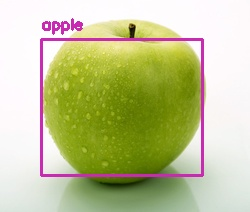

Image processed: clock.jpg

Detected object: clock with confidence level of 0.9683185815811157



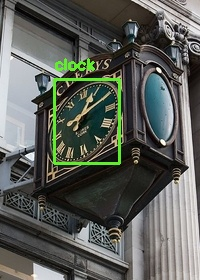

Image processed: oranges.jpg

Detected object: orange with confidence level of 0.6185590028762817

Detected object: orange with confidence level of 0.5561688542366028



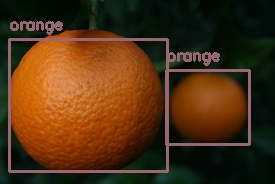

Image processed: car.jpg

Detected object: car with confidence level of 0.6325407028198242



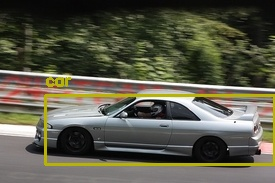

In [4]:
for image_file in image_files:
    detect_and_draw_box(image_file)

## Changing the confidence level

Looks like the object detection went fairly well. Let's try it out on a more difficult image containing several objects:

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818483829498291

Detected object: orange with confidence level of 0.5346481204032898

Detected object: orange with confidence level of 0.515099287033081



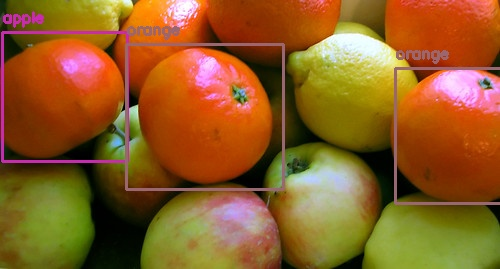

In [5]:
detect_and_draw_box("fruits.jpg")

The **model failed to detect** several fruits and **misclassified** an orange as an apple. This might seem strange since it was able to detect one apple before, so one might think the model has a fair representation on how an apple looks like.

One possibility is that the model **did** detect the other fruits but with a confidence level lower than 0.5. Let's test if  this is a valid hypothesis:

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818483829498291

Detected object: orange with confidence level of 0.5346481204032898

Detected object: orange with confidence level of 0.515099287033081

Detected object: apple with confidence level of 0.3475988507270813

Detected object: orange with confidence level of 0.3287608325481415

Detected object: apple with confidence level of 0.31244662404060364

Detected object: orange with confidence level of 0.2798607349395752

Detected object: orange with confidence level of 0.2749975323677063

Detected object: apple with confidence level of 0.2744506299495697

Detected object: orange with confidence level of 0.2141905575990677



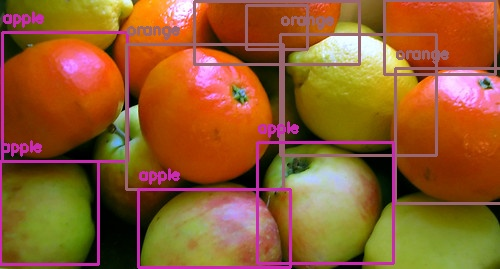

In [6]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

By lowering the confidence level the model successfully detects most of the fruits. However, in order to correctly detect the objects present, we had to  set the confidence level really low. In general, you should be careful when decreasing or increasing these kinds of parameters, as changing them might yield undesired results.

As for this concrete example when an orange was misclassified as an apple, **it serves as a reminder that these models are not perfect and this should be considered when using them for tasks in production**.

## Deploying the model using fastAPI


### Placing your object detection model in a server

Now that you know how the model works it is time for you to deploy it! Aren't you excited? :)

Before diving into deployment, let's quickly recap some important concepts and how they translate to `fastAPI`. The images that are uploaded to the server will be used within the `images_uploaded` directory.


### Some concept clarifications

#### Client-Server model

When talking about **deploying**, what is usually meant is to put all of the software required for predicting in a `server`. By doing this, a `client` can interact with the model by sending `requests` to the server. 

This client-server interaction is out of the scope of this notebook but there are a lot of resources on the internet that you can use to understand it better.

The important thing you need to focus on, is that the Machine Learning model lives in a server waiting for clients to submit prediction requests. The client should provide the required information that the model needs in order to make a prediction. Keep in mind that it is common to batch many predictions in a single request. The server will use the information provided to return predictions to the client, who can then use them at their leisure.

Let's get started by creating an instance of the `FastAPI` class:

```python
app = FastAPI()
```

The next step is using this instance to create endpoints that will handle the logic for predicting (more on this next). Once all the code is in place to run the server you only need to use the command:

```python
uvicorn.run(app)
```

Your API is coded using fastAPI but the serving is done using [`uvicorn`](https://www.uvicorn.org/), which is a really fast Asynchronous Server Gateway Interface (ASGI) implementation. Both technologies are closely interconnected and you don't need to understand the implementation details. Knowing that uvicorn handles the serving is sufficient for the purpose of this lab.

#### Endpoints

You can host multiple Machine Learning models on the same server. For this to work, you can assign a different `endpoint` to each model so you always know what model is being used. An endpoint is represented by a pattern in the `URL`. For example, if you have a website called `myawesomemodel.com` you could have three different models in the following endpoints:

- `myawesomemodel.com/count-cars/`
- `myawesomemodel.com/count-apples/`
- `myawesomemodel.com/count-plants/`

Each model would do what the name pattern suggests.

In fastAPI you define an endpoint by creating a function that will handle all of the logic for that endpoint and [decorating](https://www.python.org/dev/peps/pep-0318/) it with a function that contains information on the HTTP method allowed (more on this next) and the pattern in the URL that it will use.

The following example shows how to allow a HTTP GET request for the endpoint "/my-endpoint":

```python
@app.get("/my-endpoint")
def handle_endpoint():
    ...
    ...
```


#### HTTP Requests

The client and the server communicate with each other through a protocol called `HTTP`. The key concept here is that this communication between client and server uses some verbs to denote common actions. Two very common verbs are:

- `GET` -> Retrieves information from the server.
- `POST` -> Provides information to the server, which it uses to respond.

If your client does a `GET request` to an endpoint of a server you will get some information from this endpoint without the need to provide additional information. In the case of a `POST request` you are explicitly telling the server that you will provide some information for it that must be processed in some way.

Interactions with Machine Learning models living on endpoints are usually done via a `POST request` since you need to provide the information that is required to compute a prediction.

Let's take a look at a POST request:

```python
@app.post("/my-other-endpoint")
def handle_other_endpoint(param1: int, param2: str):
    ...
    ...

```

For POST requests, the handler function contains parameters. In contrast with GET, POST requests expect the client to provide some information to it. In this case we supplied two parameters: an integer and a string.


### Why fastAPI?

With fastAPI you can create web servers to host your models very easily. Additionally, this platform is extremely fast and it **has a built-in client that can be used to interact with the server**. To use it you will need to visit the "/docs" endpoint, you will see how to do this later on. Isn't that convenient?

Enough chatter, let's get going!

In [7]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [8]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying a ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

By running the following cell you will spin up the server!

This causes the notebook to block (no cells/code can run) until you manually interrupt the kernel. You can do this by clicking on the `Kernel` tab and then on `Interrupt`. You can also enter Jupyter's command mode by pressing the `ESC` key and tapping the `I` key twice.

In [9]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# This is an alias for localhost which means this particular machine
host = "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000, root_path="/serve")

INFO:     Started server process [64]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [64]


The server is now running! Nice job!

## Consume your service

Normally you will now head over to `http://127.0.0.1:8000/` to see it in action. However Coursera environment works somewhat different to a regular pc. Within this environment you need to interact with the service through the navigation bar, which can be found in the upper side of your screen:

<table><tr><td><img src='assets/notebook_path.png'></td></tr></table>

If you don't see this bar you might need to click on the `Navigate` button first:


<table><tr><td><img src='assets/navigate.png'></td></tr></table>

### Come back to this notebook

To come back you have two alternatives:

- Click the `Home` button at the left side of the navigation bar. 


- Type `/notebooks/server.ipynb` in the navigation bar and press enter.

### Visit the server

You can think of `/serve/` as an alias for `http://127.0.0.1:8000/`.

With this in mind, to interact with the server you need to type `/serve/` in this bar and press enter.

This will take you to the `/` endpoint of the server, which should display the message `Congratulations! Your API is working as expected`.


## Using fastAPI's integrated client

To actually use your server for image detection you can leverage the client that comes built-in with fastAPI. 

**To use this client type `/serve/docs` in the navigation bar and press enter.**

<table><tr><td><img src='assets/serve_docs.png'></td></tr></table>

Try submitting an image and see how your API is able to detect objects within it and return a new image containing the bounding boxes alongside the labels of the detected objects.

When doing so you will get a screen that should look like the one below, follow the instructions next:

<a name='instructions'></a>
## Instructions to use the client

**Note:** If you need to come back to this notebook to check these instructions you can do so as explained earlier. Remember that at the top of the notebook there is a shortcut to this section so you don't have to scroll all the way.

Click on top of the `/predict` endpoint and more options will become visible:

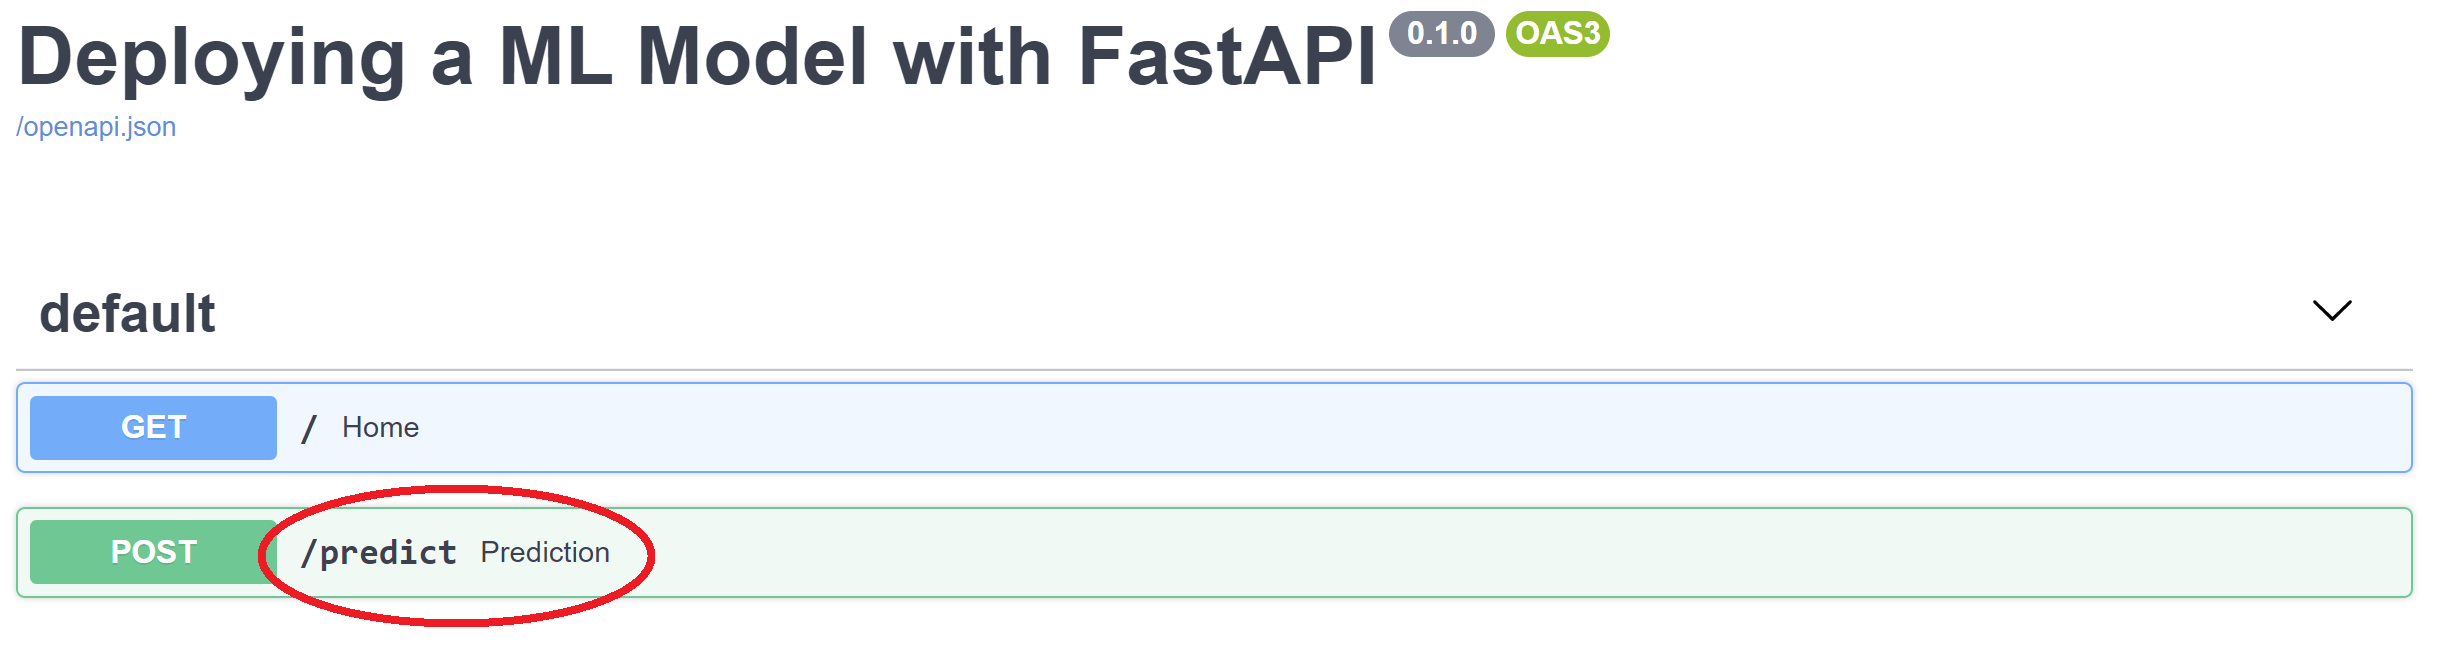



To test your server click on the **Try it out** button.

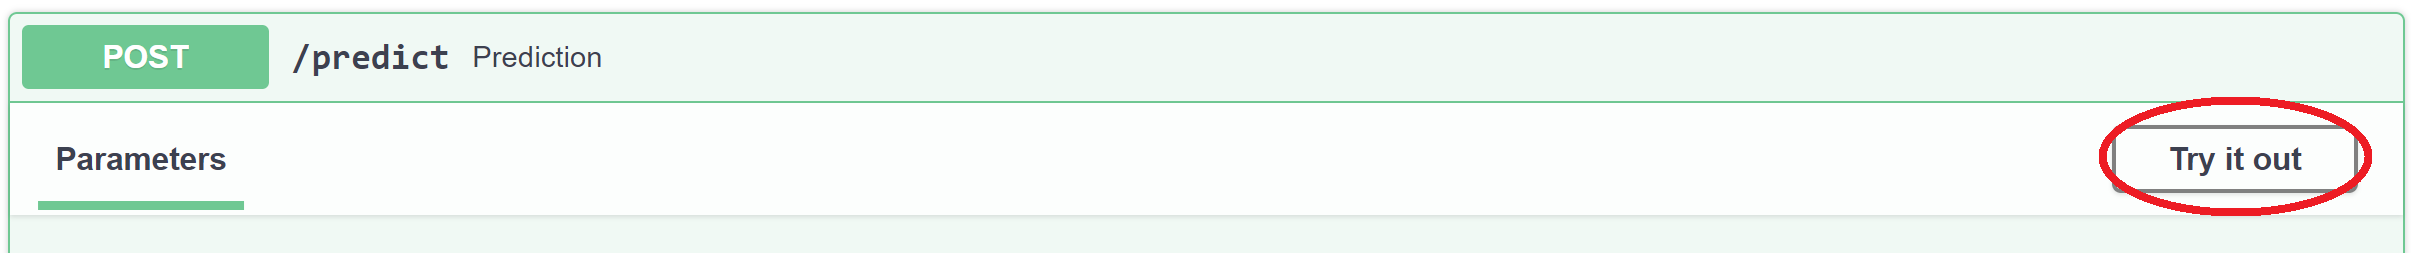

You can choose a model from the **model** field and a **file** which should be the image in which you want the server to detect objects.

**Submit an image** from your local filesystem by clicking the **Choose File** button, then click on the blue **Execute** button to send an HTTP request to the server. After doing so, **scroll down and you will see the response from it**. Pretty cool, right?

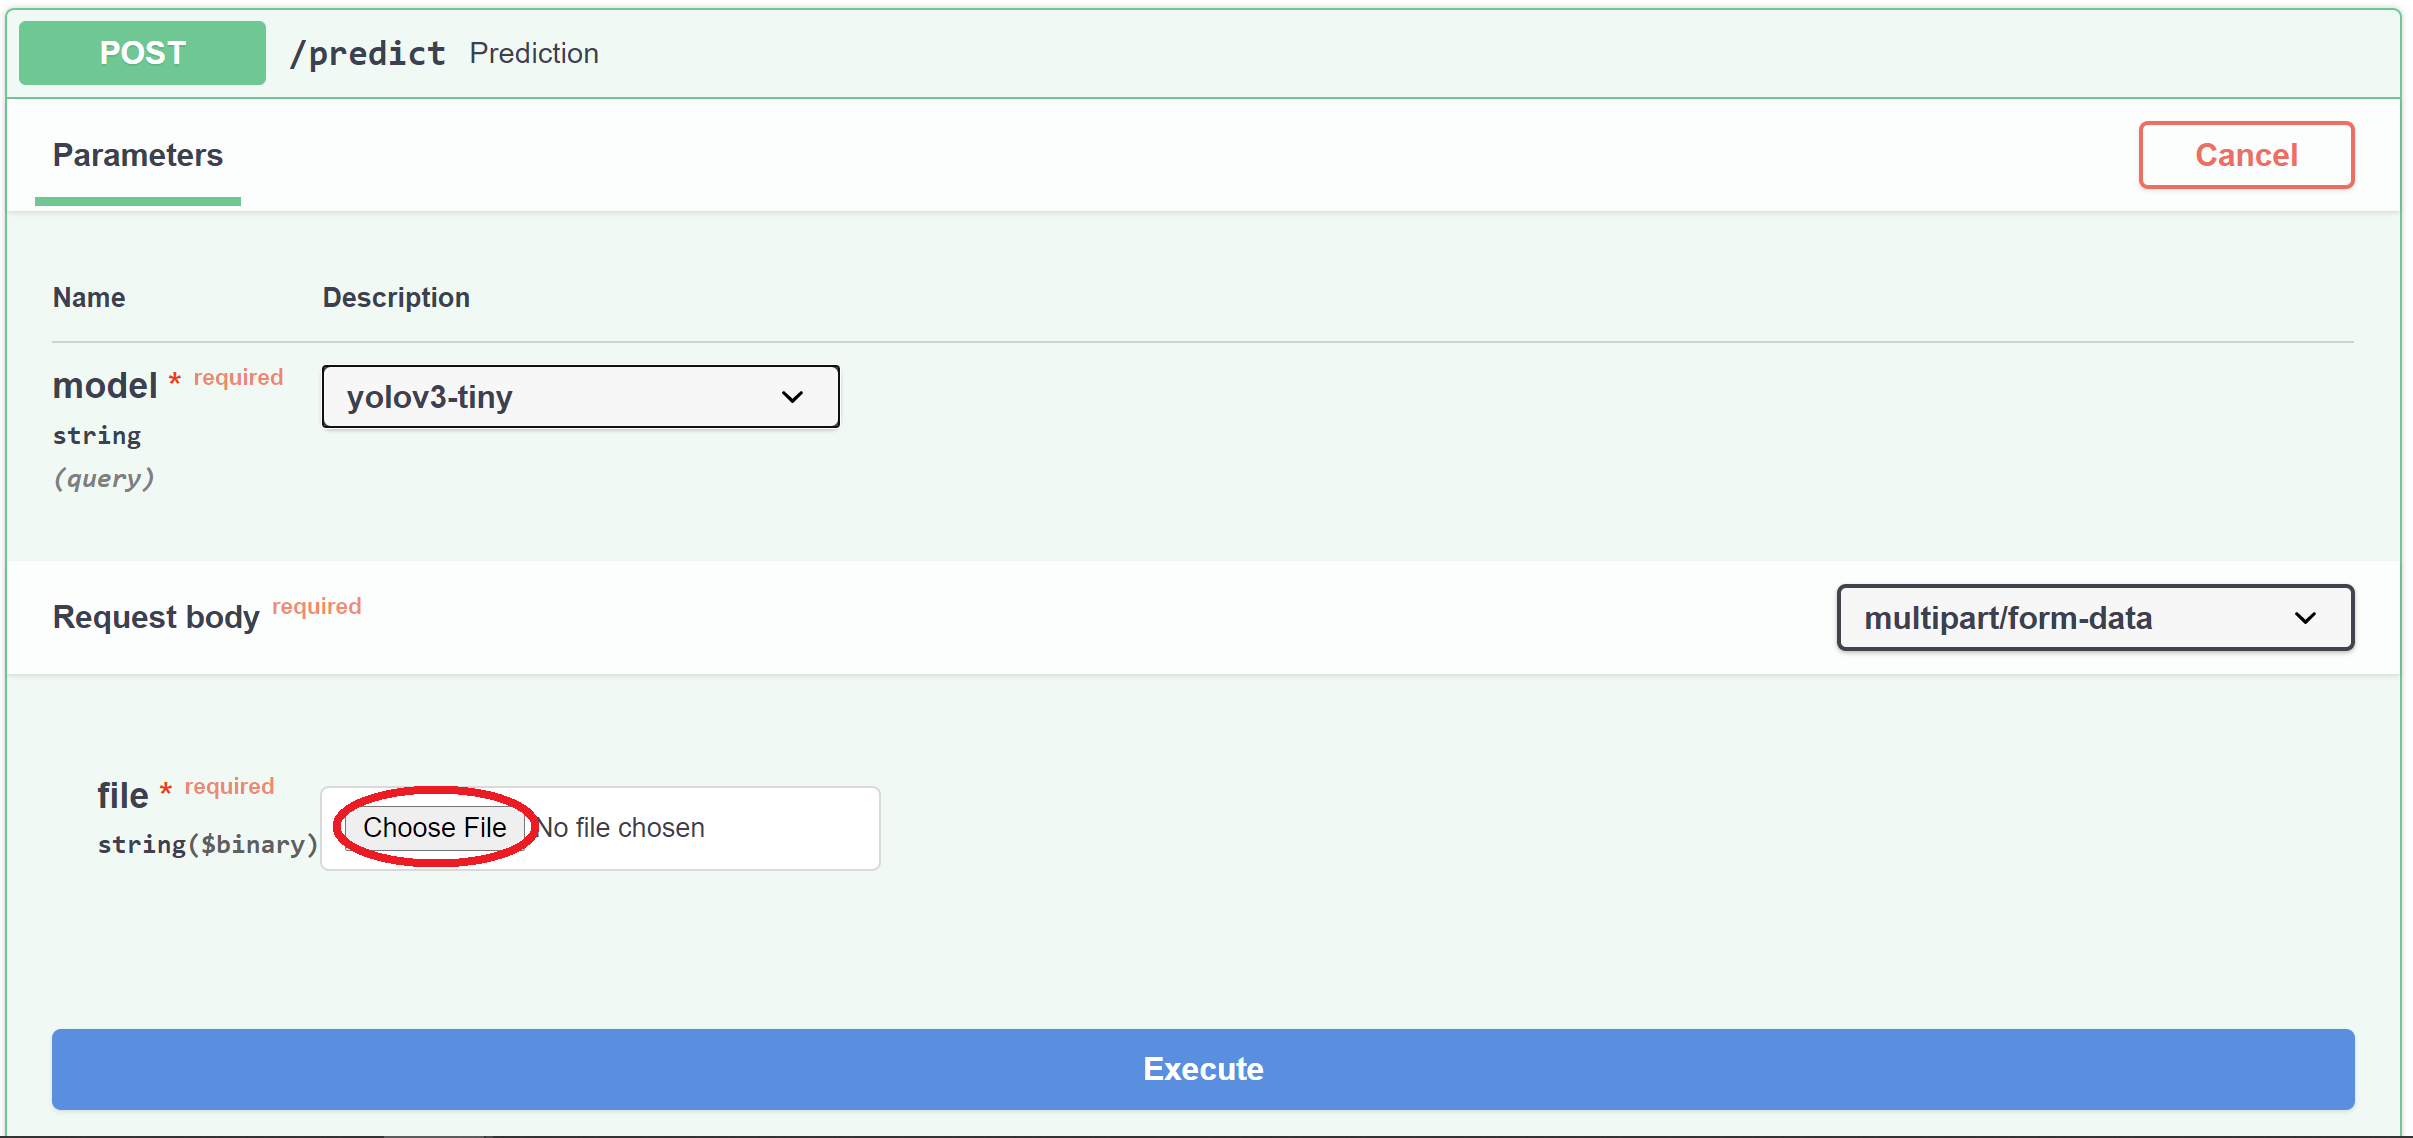

**Try different images!** You can use the ones we provided with this lab or some of your own. Since the model is using the default confidence level of 0.5 it might not always succeed to detect some objects. 

To download the images provided with lab follow these steps:

- Click on the Jupyter logo in the upper left side of the screen. This will take you to the Jupyter filesystem.


- Go into the `images` directory.


- Here you can select any image and then click on the download button to download it.

Also, try submitting non-image files and see how the server reacts to it.

## Congratulations on finishing this ungraded lab!

Real life servers have a lot more going on in terms of security and performance. However, the code you just experienced is close to what you see in real production environments. Hopefully, this lab served the purpose of increasing your familiarity with the process of deploying a Deep Learning model, and consuming from it.

**Keep it up!**

## Consuming your model from another client

It is awesome that fastAPI allows you to interact with your API through its built-in client. However, you might wonder how you can interact with your API using regular code and not some UI.

There is a bonus section which shows how to code a minimal client in Python. This is useful to break down (in a very high level) what fastAPI's client is doing under the hood. However this section cannot be used within Coursera's environment. For this reason consider checking out the version of this lab that is meant to be run within your local computer. You can find it [here](https://github.com/https-deeplearning-ai/machine-learning-engineering-for-production-public/tree/main/course1/week1-ungraded-lab).